How to run colab locally:

Step 1: Install Jupyter.

___________________________________________________________

Step 2: Install and enable the jupyter_http_over_ws jupyter extension (one-time): 

pip install jupyter_http_over_ws jupyter serverextension enable --py jupyter_http_over_ws

___________________________________________________________

Step 3: Start server and authenticate:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

___________________________________________________________

Step 4: Connect to the local runtime:
In Colaboratory, click the "Connect" button and select "Connect to local runtime...". Enter the URL from the previous step in the dialog that appears and click the "Connect" button. After this, you should now be connected to your local runtime.



In [ ]:
!nvidia-smi -L

GPU 0: GeForce RTX 3090 (UUID: GPU-921707b2-707c-5390-d2c9-a0614d08613f)
GPU 1: GeForce RTX 3090 (UUID: GPU-444b9dae-5964-1d63-07f0-88ed2d5c936d)


In [ ]:
import os
entries = os.listdir('/home/pc6/MS internship/ISBI rater2OnlyPatches')
entries.sort(key=len)
print(entries)
print(len(entries))

['patch201', 'patch186', 'patch242', 'patch180', 'patch258', 'patch307', 'patch285', 'patch256', 'patch209', 'patch211', 'patch275', 'patch210', 'patch278', 'patch281', 'patch231', 'patch235', 'patch272', 'patch314', 'patch300', 'patch261', 'patch178', 'patch190', 'patch270', 'patch181', 'patch165', 'patch199', 'patch234', 'patch173', 'patch268', 'patch222', 'patch233', 'patch317', 'patch302', 'patch251', 'patch312', 'patch203', 'patch253', 'patch305', 'patch236', 'patch244', 'patch192', 'patch288', 'patch212', 'patch246', 'patch286', 'patch189', 'patch168', 'patch298', 'patch205', 'patch208', 'patch196', 'patch294', 'patch225', 'patch207', 'patch198', 'patch297', 'patch172', 'patch282', 'patch248', 'patch290', 'patch255', 'patch292', 'patch221', 'patch239', 'patch304', 'patch247', 'patch262', 'patch161', 'patch183', 'patch213', 'patch179', 'patch283', 'patch229', 'patch200', 'patch219', 'patch193', 'patch250', 'patch274', 'patch260', 'patch263', 'patch182', 'patch265', 'patch243', 'pa

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# Data

In this notebook we use the pretrined model on the BraTS2020 dataset in order to segment MS lesions MRI scans

# Formulation of the problem:
+  Each pixel must be labeled “1” if it is a tumor, and “0” if not.


# Solution
+ 1. For automatic segmentation we will use VNet


In [ ]:
!pip install tqdm
from tqdm import tqdm
import os
import time
from random import randint

!pip install albumentations==0.4.6
!pip install pandas

import numpy as np
from scipy import stats
import pandas as pd

!pip install sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import KFold

!pip install nibabel
import nibabel as nib
!pip install pydicom
import pydicom as pdm
!pip install nilearn
import nilearn as nl
import nilearn.plotting as nlplt
!pip install h5py
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

!pip install seaborn
import seaborn as sns
import imageio
from skimage.transform import resize
from skimage.util import montage

from IPython.display import Image as show_gif
from IPython.display import clear_output
from IPython.display import YouTubeVideo

!pip install torchvision 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import MSELoss

!pip install albumentations==0.4.6
import albumentations as A
from albumentations import Compose, HorizontalFlip
from albumentations.pytorch import ToTensor, ToTensorV2

!pip install patchify
from patchify import patchify,unpatchify

import warnings
warnings.simplefilter("ignore")

/home/pc6/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [ ]:
class Image3dToGIF3d:
    """
    Displaying 3D images in 3d axes.
    Parameters:
        img_dim: shape of cube for resizing.
        figsize: figure size for plotting in inches.
    """
    def __init__(self, 
                 img_dim: tuple = (55, 55, 55),
                 figsize: tuple = (15, 10),
                 binary: bool = False,
                 normalizing: bool = True,
                ):
        """Initialization."""
        self.img_dim = img_dim
        print(img_dim)
        self.figsize = figsize
        self.binary = binary
        self.normalizing = normalizing

    def _explode(self, data: np.ndarray):
        """
        Takes: array and return an array twice as large in each dimension,
        with an extra space between each voxel.
        """
        shape_arr = np.array(data.shape)
        size = shape_arr[:3] * 2 - 1
        exploded = np.zeros(np.concatenate([size, shape_arr[3:]]),
                            dtype=data.dtype)
        exploded[::2, ::2, ::2] = data
        return exploded

    def _expand_coordinates(self, indices: np.ndarray):
        x, y, z = indices
        x[1::2, :, :] += 1
        y[:, 1::2, :] += 1
        z[:, :, 1::2] += 1
        return x, y, z
    
    def _normalize(self, arr: np.ndarray):
        """Normilize image value between 0 and 1."""
        arr_min = np.min(arr)
        return (arr - arr_min) / (np.max(arr) - arr_min)

    
    def _scale_by(self, arr: np.ndarray, factor: int):
        """
        Scale 3d Image to factor.
        Parameters:
            arr: 3d image for scalling.
            factor: factor for scalling.
        """
        mean = np.mean(arr)
        return (arr - mean) * factor + mean
    
    def get_transformed_data(self, data: np.ndarray):
        """Data transformation: normalization, scaling, resizing."""
        if self.binary:
            resized_data = resize(data, self.img_dim, preserve_range=True)
            return np.clip(resized_data.astype(np.uint8), 0, 1).astype(np.float32)
            
        norm_data = np.clip(self._normalize(data)-0.1, 0, 1) ** 0.4
        scaled_data = np.clip(self._scale_by(norm_data, 2) - 0.1, 0, 1)
        resized_data = resize(scaled_data, self.img_dim, preserve_range=True)
        
        return resized_data
    
    def plot_cube(self,
                  cube,
                  title: str = '', 
                  init_angle: int = 0,
                  make_gif: bool = False,
                  path_to_save: str = 'filename.gif'
                 ):
        """
        Plot 3d data.
        Parameters:
            cube: 3d data
            title: title for figure.
            init_angle: angle for image plot (from 0-360).
            make_gif: if True create gif from every 5th frames from 3d image plot.
            path_to_save: path to save GIF file.
            """
        if self.binary:
            facecolors = cm.winter(cube)
            print("binary")
        else:
            if self.normalizing:
                cube = self._normalize(cube)
            facecolors = cm.gist_stern(cube)
            print("not binary")
            
        facecolors[:,:,:,-1] = cube
        facecolors = self._explode(facecolors)

        filled = facecolors[:,:,:,-1] != 0
        x, y, z = self._expand_coordinates(np.indices(np.array(filled.shape) + 1))

        with plt.style.context("dark_background"):

            fig = plt.figure(figsize=self.figsize)
            ax = fig.gca(projection='3d')

            ax.view_init(30, init_angle)
            ax.set_xlim(right = self.img_dim[0] * 2)
            ax.set_ylim(top = self.img_dim[1] * 2)
            ax.set_zlim(top = self.img_dim[2] * 2)
            ax.set_title(title, fontsize=18, y=1.05)

            ax.voxels(x, y, z, filled, facecolors=facecolors, shade=False)

            if make_gif:
                images = []
                for angle in tqdm(range(0, 360, 5)):
                    ax.view_init(30, angle)
                    fname = str(angle) + '.png'

                    plt.savefig(fname, dpi=120, format='png', bbox_inches='tight')
                    images.append(imageio.imread(fname))
                    #os.remove(fname)
                imageio.mimsave(path_to_save, images)
                plt.close()

            else:
                plt.show()

                
class ShowResult:
  
    def mask_preprocessing(self, mask):
        """
        Test.
        """
        mask = mask.squeeze().cpu().detach().numpy()
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        mask_WT = np.rot90(montage(mask[0]))
        mask_TC = np.rot90(montage(mask[1]))
        mask_ET = np.rot90(montage(mask[2]))

        return mask_WT, mask_TC, mask_ET

    def image_preprocessing(self, image):
        """
        Returns image flair as mask for overlaping gt and predictions.
        """
        image = image.squeeze().cpu().detach().numpy()
        image = np.moveaxis(image, (0, 1, 2, 3), (0, 3, 2, 1))
        flair_img = np.rot90(montage(image[0]))
        return flair_img
    
    def plot(self, image, ground_truth, prediction):
        image = self.image_preprocessing(image)
        gt_mask_WT, gt_mask_TC, gt_mask_ET = self.mask_preprocessing(ground_truth)
        pr_mask_WT, pr_mask_TC, pr_mask_ET = self.mask_preprocessing(prediction)
        
        fig, axes = plt.subplots(1, 2, figsize = (35, 30))
    
        [ax.axis("off") for ax in axes]
        axes[0].set_title("Ground Truth", fontsize=35, weight='bold')
        axes[0].imshow(image, cmap ='bone')
        axes[0].imshow(np.ma.masked_where(gt_mask_WT == False, gt_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_TC == False, gt_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[0].imshow(np.ma.masked_where(gt_mask_ET == False, gt_mask_ET),
                  cmap='autumn', alpha=0.6)

        axes[1].set_title("Prediction", fontsize=35, weight='bold')
        axes[1].imshow(image, cmap ='bone')
        axes[1].imshow(np.ma.masked_where(pr_mask_WT == False, pr_mask_WT),
                  cmap='cool_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_TC == False, pr_mask_TC),
                  cmap='autumn_r', alpha=0.6)
        axes[1].imshow(np.ma.masked_where(pr_mask_ET == False, pr_mask_ET),
                  cmap='autumn', alpha=0.6)

        plt.tight_layout()
        
        plt.show()
        
#show_result = ShowResult()
#show_result.plot(data['image'], data['mask'], data['mask'])


def merging_two_gif(path1: str, path2: str, name_to_save: str):
    """
    Merging GIFs side by side.
    Parameters:
        path1: path to gif with ground truth.
        path2: path to gif with prediction.
        name_to_save: name for saving new GIF.
    """
    #https://stackoverflow.com/questions/51517685/combine-several-gif-horizontally-python
    #Create reader object for the gif
    gif1 = imageio.get_reader(path1)
    gif2 = imageio.get_reader(path2)

    #If they don't have the same number of frame take the shorter
    number_of_frames = min(gif1.get_length(), gif2.get_length()) 

    #Create writer object
    new_gif = imageio.get_writer(name_to_save)

    for frame_number in range(number_of_frames):
        img1 = gif1.get_next_data()
        img2 = gif2.get_next_data()
        #here is the magic
        new_image = np.hstack((img1, img2))
        new_gif.append_data(new_image)

    gif1.close()
    gif2.close()    
    new_gif.close()
    
#merging_two_gif('BraTS20_Training_001_flair_3d.gif',
#                'BraTS20_Training_001_flair_3d.gif', 
#                'result.gif')

def get_all_csv_file(root: str) -> list:
    """Extraction all unique ids from file names."""
    ids = []
    for dirname, _, filenames in os.walk(root):
        for filename in filenames:
            path = os.path.join(dirname, filename)
            if path.endswith(".csv"):
                ids.append(path) 
    ids = list(set(filter(None, ids)))
    print(f"Extracted {len(ids)} csv files.")
    return ids

#csv_paths = get_all_csv_file("../input/brats20-dataset-training-validation/BraTS2020_TrainingData")

#Config

In [ ]:
# class GlobalConfig:
#     root_dir = '/content/gdrive/MyDrive/BraTS2020'
#     train_root_dir = '/content/gdrive/MyDrive/BraTS2020/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
#     test_root_dir = '/content/gdrive/MyDrive/BraTS2020/MICCAI_BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
#     path_to_csv = '/content/train_data.csv'

#     ms_root_dir = '/content/gdrive/MyDrive/ISBI_test'
#     ms_train_root_dir = '/content/gdrive/MyDrive/ISBI'
#     path_to_csv1 = '/content/train_data1.csv'


#     # pretrained_model_path = '/content/gdrive/MyDrive/BraTS2020/last_epoch_model.pth'
#     # train_logs_path = '/content/gdrive/MyDrive/BraTS2020/train_log.csv'
#     pretrained_model_path = '/content/gdrive/MyDrive/Pretrained downloaded/last_epoch_model.pth'
#     train_logs_path = '/content/gdrive/MyDrive/Pretrained downloaded/train_log.csv'
#     ae_pretrained_model_path = None
#     tab_data = None
#     seed = 55
#     MSpretrained_model_path = '/content/gdrive/MyDrive/last_epoch_model.pth'
    
# def seed_everything(seed: int):
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
    
# config = GlobalConfig()
# seed_everything(config.seed)

Data Preprocessing

# Metric and Loss

In [ ]:
def get_score(SR,GT,threshold=0.50):
    
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    TPFP = SR.sum()
    TPFN = GT.sum()
    TP=TP.item()
    FP=TPFP.item() - TP
    FN=TPFN.item() - TP
    dice=(2*TP)/((2*TP)+FP+FN+eps)
    pre=TP/(TPFP.item()+eps)
    rec=TP/(TPFN.item()+eps)
    print("TP: ",TP)
    print("FP: ",FP)
    print("FN: ",FN)
    print("DSC: ",dice)
    print("Precision: ",pre)
    print("Recall: ",rec)
    print("___________________________")
    return dice

def get_TP(SR,GT,threshold=0.5):

    scores = []
    num = SR.shape[0]
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    # TPFP = SR.sum()
    scores.append(TP.item())
    # return np.mean(scores)
    return TP

def get_FP(SR,GT,threshold=0.5):

    scores = []
    num = SR.shape[0]
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    TP=TP.item()
    TPFP = SR.sum()
    FP=TPFP.item() - TP
    scores.append(FP)
    # return np.mean(scores)
    return FP
    
def get_FN(SR,GT,threshold=0.5):

    scores = []
    num = SR.shape[0]
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    TP=TP.item()
    TPFN = GT.sum()
    # FP=TPFP.item() - TP
    FN=TPFN.item() - TP
    scores.append(FN)
    # return np.mean(scores)
    return FN

    
def get_precision(SR,GT,threshold=0.5):
    # SR = SR > threshold
    # GT = GT == torch.max(GT)

    # # TP : True Positive
    # # FP : False Positive
    # TP = ((SR==1)+(GT==1))==2
    # FP = ((SR==1)+(GT==0))==2

    # PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-9)

    # return PC

    scores = []
    num = SR.shape[0]
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    TPFP = SR.sum()
    scores.append((TP) / (TPFP+ 1e-9))
    # for i in range(num):
    #     SR1 = SR[i]
    #     GT1 = GT[i]
    #     TP =  (GT1 * SR1).sum()
    #     TPFP = SR1.sum()
    #     if GT1.sum() == 0 and SR1.sum() == 0:
    #         scores.append(1.0)
    #     else:
    #         scores.append((TP + eps) / TPFP)
    return np.mean(scores)

def get_sensitivity(SR,GT,threshold=0.5):
    # scores = []
    # # Sensitivity == Recall
    # SR = SR > threshold
    # GT = GT == torch.max(GT)

    # # TP : True Positive
    # # FN : False Negative
    # TP = ((SR==1)+(GT==1))==2
    # FN = ((SR==0)+(GT==1))==2

    # SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-9)     
    
    # return SE
    scores = []
    num = SR.shape[0]
    SR = (SR >= threshold).float()
    eps=1e-9
    assert(SR.shape == GT.shape)
    TP=(SR*GT).sum()
    TPFN = GT.sum()
    scores.append((TP) / (TPFN+ 1e-9))
    # for i in range(num):
    #     SR1 = SR[i]
    #     GT1 = GT[i]
    #     TP =  (GT1 * SR1).sum()
    #     TPFN = GT1.sum()
    #     if GT1.sum() == 0 and SR1.sum() == 0:
    #         scores.append(1.0)
    #     else:
    #         scores.append((TP + eps) / TPFN)
    return np.mean(scores)

def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
        self.precision_scores: list = []
        self.recall_scores: list = []
        self.true_positives: list= []
        self.false_positives: list= []
        self.false_negatives: list= []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        dice = get_score(probs,targets)
        
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        precision= get_precision(probs,targets, self.threshold)
        recall= get_sensitivity(probs,targets, self.threshold)
        tp=get_TP(probs,targets,self.threshold)
        fp=get_FP(probs,targets,self.threshold)
        fn=get_FN(probs,targets,self.threshold)


        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)
        self.true_positives.append(tp)
        self.false_positives.append(fp)
        self.false_negatives.append(fn)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        precision=np.mean(self.precision_scores)
        recall=np.mean(self.recall_scores)
        tp=np.sum(self.true_positives)
        fp=np.sum(self.false_positives)
        fn=np.sum(self.false_negatives)

        return dice, iou, precision, recall, tp, fp, fn


class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        # print(logits.shape) #PROBLEM HERE
        # print(targets.shape) #PROBLEM HERE
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss
    
# helper functions for testing.  
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['WT', 'TC', 'ET']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores

# 3DUnet

In [ ]:
class DoubleConv(nn.Module):
    """(Conv3D -> BN -> ReLU) * 2"""
    def __init__(self, in_channels, out_channels, num_groups=8):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True),

            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm3d(out_channels),
            nn.GroupNorm(num_groups=num_groups, num_channels=out_channels),
            nn.ReLU(inplace=True)
          )

    def forward(self,x):
        return self.double_conv(x)

    
class Down(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(2, 2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.encoder(x)

    
class Up(nn.Module):

    def __init__(self, in_channels, out_channels, trilinear=True):
        super().__init__()
        
        if trilinear:
            self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffZ = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        diffX = x2.size()[4] - x1.size()[4]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2, diffZ // 2, diffZ - diffZ // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

    
class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)


class UNet3d(nn.Module):
    def __init__(self, in_channels, n_classes, n_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.n_channels = n_channels

        self.conv = DoubleConv(in_channels, n_channels)
        self.enc1 = Down(n_channels, 2 * n_channels)
        self.enc2 = Down(2 * n_channels, 4 * n_channels)
        self.enc3 = Down(4 * n_channels, 8 * n_channels)
        self.enc4 = Down(8 * n_channels, 8 * n_channels)

        self.dec1 = Up(16 * n_channels, 4 * n_channels)
        self.dec2 = Up(8 * n_channels, 2 * n_channels)
        self.dec3 = Up(4 * n_channels, n_channels)
        self.dec4 = Up(2 * n_channels, n_channels)
        self.out = Out(n_channels, n_classes)

    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)

        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        return mask

#MS Dataset DataLoader

In [ ]:
class MSDataset(Dataset):

  def __init__(self,is_resize: bool=True, phase: str="train"):
    # self.data_types = ['_FLAIR_pp.nii', '_T1WKS_pp.nii', '_T1W_pp.nii','_T2W_pp.nii']
    self.augmentations = get_augmentations(phase)
    self.is_resize = is_resize
    self.phase=phase

  
  def __len__(self):
    return len(entries)
  
  def __getitem__(self,idx):
    i=idx
    # /content/gdrive/MyDrive/3D MR image MS 30 patients/patient01/preprocessed/patient01_FLAIR_pp.nii.gz
    images = []
    # data_types = ['_FLAIR_pp.nii.gz', '_T1WKS_pp.nii.gz', '_T1W_pp.nii.gz','_T2W_pp.nii.gz']
    data_types = ['_flair_pp.nii', '_mprage_pp.nii', '_t2_pp.nii','_pd_pp.nii']
    folder_path='/home/pc6/MS internship/ISBI rater2OnlyPatches/'+entries[i]
    x='/'+entries[i]
    img_path = folder_path+x
    print(img_path)
    # img = self.load_img(img_path)#.transpose(2, 0, 1)
    is_resize=True
    # s=img_path+data_types[0]
    # size = self.load_img(s)#.transpose(2, 0, 1)
    # xs,ys,zs = np.where(size!=0)
    # img=img[min(xs)-1:max(xs)+1,min(ys)-1:max(ys)+1,min(zs)-1:max(zs)+1]
    for data_type in data_types:
            img_path_type = img_path+data_type
            img = self.load_img(img_path_type)#.transpose(2, 0, 1)
            # xs,ys,zs = np.where(img!=0)
            # img=img[min(xs)-4:max(xs)+4,min(ys)-4:max(ys)+4,min(zs)-4:max(zs)+4]
            # print(img.shape)
            
            # if is_resize:
            #     img = self.resize(img)
    
            img = self.normalize(img)
            images.append(img)  
    img = np.stack(images) #problem is here
    img = np.moveaxis(img, (0, 1, 2, 3), (0, 3, 2, 1))
    
    if self.phase != "test":
            # mask_p='/'+entries[i]+'_consensus_gt.nii.gz'
            mask_p='/'+entries[i]+'_mask1.nii'
            mask_path=folder_path+mask_p
            # print(mask_path)
            mask = self.load_img(mask_path)
            # mask=mask[min(xs)-4:max(xs)+4,min(ys)-4:max(ys)+4,min(zs)-4:max(zs)+4]
            
            mask = self.preprocess_mask_labels(mask)
    
            augmented = self.augmentations(image=img.astype(np.float32), 
                                           mask=mask.astype(np.float32))
            
            img = augmented['image']
            mask = augmented['mask']
    
        
            return {
                "image": img,
                "mask": mask,
            }
    

    return {"image": img}

  def load_img(self, file_path):
        data = nib.load(file_path)
        data = np.asarray(data.dataobj)
        return data
    
  def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        return (data - data_min) / (np.max(data) - data_min)
    
  def resize(self, data: np.ndarray):
        data = resize(data, (240, 240, 155), preserve_range=False) #?
        return data
    
  def preprocess_mask_labels(self, mask: np.ndarray):

        mask_WT = mask.copy()
        # mask_WT[mask_WT == 1] = 1
        # mask_WT[mask_WT == 2] = 1
        # mask_WT[mask_WT == 4] = 1

        # mask_TC = mask.copy()
        # mask_TC[mask_TC == 1] = 1
        # mask_TC[mask_TC == 2] = 0
        # mask_TC[mask_TC == 4] = 1

        # mask_ET = mask.copy()
        # mask_ET[mask_ET == 1] = 0
        # mask_ET[mask_ET == 2] = 0
        # mask_ET[mask_ET == 4] = 1

        # mask = np.stack([mask_WT, mask_TC, mask_ET])
        mask = np.stack([mask_WT])
        mask = np.moveaxis(mask, (0, 1, 2, 3), (0, 3, 2, 1))

        return mask
  


In [ ]:
def get_augmentations(phase):
    list_transforms = []
    
    list_trfms = Compose(list_transforms)
    return list_trfms

from sklearn.model_selection import KFold    
from torch.utils.data import SubsetRandomSampler
# kfold = KFold(n_splits=5, shuffle=True)

# def get_dataloader(train_idx: np.ndarray,
#     val_idx: np.ndarray,
#     dataset: torch.utils.data.Dataset,
#     phase: str,
#     fold: int = 0,
#     batch_size: int = 1,
#     num_workers: int = 1,

# ):

def get_dataloader(
    dataset: torch.utils.data.Dataset,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 1,

):
    validation_split = 0.2
    dataset_size = len(entries)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    # train_idx, val_idx = indices[(dataset_size//2):], indices[:(dataset_size//2)]

    shuffle_dataset=True
    random_seed=5
    if shuffle_dataset :
        np.random.seed(random_seed)
    np.random.shuffle(indices)
    # indices=val_idx+train_idx
    train_idx, val_idx = indices[split:], indices[:split]
    # print(val_idx)
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    if(phase=='train'):
      sampler=train_sampler
    else:
      sampler=valid_sampler
    # for fold, (train_ids, valid_ids) in enumerate(kfold.split(dataset)):
    
    #   # Print
    #   print(f'FOLD {fold}')
    #   print('--------------------------------')
      
    #   # Sample elements randomly from a given list of ids, no replacement.
    #   train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
    #   valid_sampler = torch.utils.data.SubsetRandomSampler(valid_ids)

      '''Returns: dataloader for the model training'''
    dataset = dataset()
    dataloader = DataLoader(
          dataset,
          batch_size=batch_size,
          num_workers=num_workers,
          pin_memory=True,
          sampler=sampler   
    )
      # dataset = dataset()
      # dataloader = DataLoader(
      #     dataset,
      #     batch_size=batch_size,
      #     num_workers=num_workers,
      #     pin_memory=True,
      #     shuffle=True,   
      # )
    return dataloader

In [ ]:
dataset=MSDataset()
dataloader = get_dataloader(dataset=MSDataset, phase='valid', fold=0)
len(dataloader)

32

In [ ]:
data = next(iter(dataloader))
print(data['image'].shape) 
print(data['mask'].shape)

/home/pc6/MS internship/ISBI rater2OnlyPatches/patch199/patch199
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch295/patch295
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch168/patch168
torch.Size([1, 4, 100, 217, 100])
torch.Size([1, 1, 100, 217, 100])


# MS Trainer

In [ ]:
class MSTrainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(
                 self,
                 net: nn.Module,
                 dataset: torch.utils.data.Dataset,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 fold: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        """Initialization."""
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=15, verbose=True,factor=0.001)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.fold=fold
        # self.train_idx=train_idx
        # self.val_idx=val_idx

        self.dataloaders = {
            phase: get_dataloader(
                dataset = dataset,
                phase = phase,
                fold = fold,
                batch_size = batch_size,
                num_workers = 1,
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
        self.precision_scores = {phase: [] for phase in self.phases}
        self.recall_scores = {phase: [] for phase in self.phases}
        self.true_positives = {phase: [] for phase in self.phases}
        self.false_positives = {phase: [] for phase in self.phases}
        self.false_negatives = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        print('shape: ',images.shape)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        del targets
        del images
        torch.cuda.empty_cache()
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, data_batch in enumerate(dataloader):
            images, targets = data_batch['image'], data_batch['mask']
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                        targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / (total_batches)
        epoch_dice, epoch_iou, epoch_precision, epoch_recall , epoch_tp , epoch_fp , epoch_fn = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)
        self.precision_scores[phase].append(epoch_precision)
        self.recall_scores[phase].append(epoch_recall)
        self.true_positives[phase].append(epoch_tp)
        self.false_positives[phase].append(epoch_fp)
        self.false_negatives[phase].append(epoch_fn)

        # print("precision ",epoch_precision)
        # print("recall ",epoch_recall)

        return epoch_loss
        
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                self._save_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                # torch.save(self.net.state_dict(), f"unet_best_model_fold{fold}_3dMS.pth")
                torch.save(self.net.state_dict(), f'/home/pc6/MS internship/20 sep checkpoints correctAug isbi/unet_best_model_patches_Rater2Only_AllLayers_4PatchesNoOverlap_lr=0.001_patience15_batchsize4.pth')
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        # print("precision ", self.precision_scores['train'][-1])
        # print("recall ", self.recall_scores['train'][-1])
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        # torch.save(self.net.state_dict(),
        #            f"unet_last_epoch_model_fold{fold}_3dMS.pth")
        torch.save(self.net.state_dict(), f'/home/pc6/MS internship/20 sep checkpoints correctAug isbi/unet_last_epoch_model_patches_Rater2Only_AllLayers_4PatchesNoOverlap_lr=0.001_patience15_batchsize4.pth')

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores, self.precision_scores, self.recall_scores, self.true_positives, self.false_positives, self.false_negatives]
        log_names_ = ["_loss", "_dice", "_jaccard","_precision", "_recall", "_truePositives", "_falsePositives", "_falseNegatives"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        # pd.DataFrame(
        #     dict(zip(log_names, logs))
        # ).to_csv(f"unet_train_log_fold{fold}_3dMS.csv", index=False)
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv(f"/home/pc6/MS internship/20 sep checkpoints correctAug isbi/unet_train_log_patches_Rater2Only_AllLayers_4PatchesNoOverlap_lr=0.001_patience15_batchsize4.csv", index=False)
        # !cp unet_train_log_MS.csv /home/internship/ISBI\ checkpoints

#Load pretrained model

In [ ]:
model = UNet3d(in_channels=4, n_classes=3, n_channels=24).to('cuda:0')

# model.load_state_dict(torch.load('/media/pc6/My Passport/BraTS2020/unet training checkpoints/30 epochs/unet_best_model.pth'))
model.load_state_dict(torch.load('/home/internship/BraTS2020/unet training checkpoints/30 epochs/unet_best_model.pth',map_location='cuda:0'))
#model.eval()
print(model)

UNet3d(
  (conv): DoubleConv(
    (double_conv): Sequential(
      (0): Conv3d(4, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): GroupNorm(8, 24, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(24, 24, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (4): GroupNorm(8, 24, eps=1e-05, affine=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc1): Down(
    (encoder): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv3d(24, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): GroupNorm(8, 48, eps=1e-05, affine=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(48, 48, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (4): GroupNorm(8, 48, eps=1e-05, affine=True)
          (5): ReLU(inplace=True)
        )
      )
    )
  )
  (enc2): Down(
   

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

model.out=Out(24, 1)

for param in model.dec4.parameters():
    param.requires_grad = True

for param in model.dec3.parameters():
    param.requires_grad = True

for param in model.out.parameters():
    param.requires_grad = True

for param in model.dec2.parameters():
    param.requires_grad = True

for param in model.dec1.parameters():
    param.requires_grad = True

pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_trainable=sum(p.numel() for p in model.parameters() if p.requires_grad)
print("trainable parameters:",pytorch_total_trainable,", total parameters:",pytorch_total_params)

trainable parameters: 5652457 , total parameters: 5652457


#trainer run

In [ ]:
trainer = MSTrainer(net=model,
                  dataset=MSDataset,
                  criterion=BCEDiceLoss(),
                  lr=0.001,
                  accumulation_steps=8,
                  batch_size=4,
                  fold=0,
                  num_epochs=100,)

# if config.pretrained_model_path is not None:
#     trainer.load_predtrain_model(config.pretrained_model_path)
# trainer.load_predtrain_model('/content/gdrive/MyDrive/ISBI training checkpoints/all patients best model/last_epoch_model_MS.pth')
    
#     # if need - load the logs.      
# train_logs = pd.read_csv('/contenpytorch_total_params = sum(p.numel() for p in model.parameters())
# pytorch_total_trainable=sum(p.numel() for p in model.parameters() if p.requires_grad)
# print("trainable parameters:",pytorch_total_trainable,", total parameters:",pytorch_total_params)t/gdrive/MyDrive/train_log_MS.csv')
# trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
# trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
# trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
# trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
# trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
# trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()




device: cuda:0


#MS training run

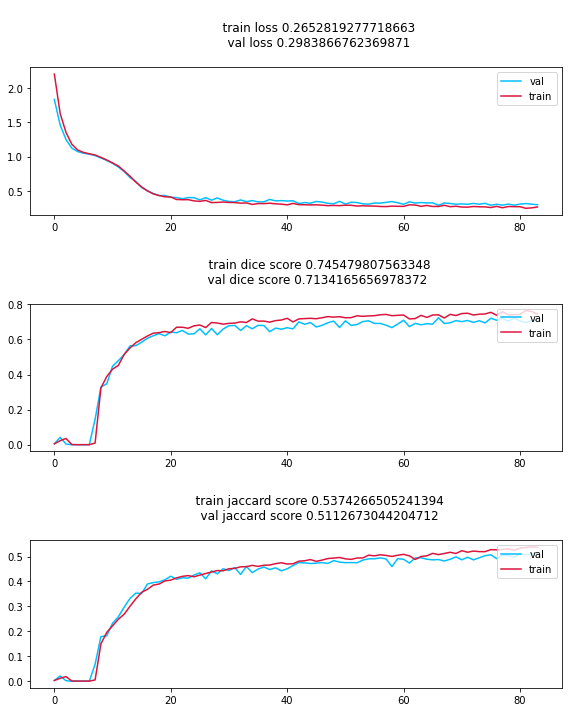


train epoch: 84 | time: 15:41:11
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch180/patch180
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch285/patch285
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch209/patch209
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch290/patch290


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


/home/pc6/MS internship/ISBI rater2OnlyPatches/patch293/patch293
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch185/patch185
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch166/patch166
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch275/patch275
shape:  torch.Size([4, 4, 100, 217, 100])
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch316/patch316
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch242/patch242
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch252/patch252
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch233/patch233
TP:  18135.0
FP:  3004.0
FN:  6681.0
DSC:  0.7892503536067721
Precision:  0.8578929939921066
Recall:  0.7307785299806282
___________________________
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch248/patch248
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch257/patch257
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch298/patch298
/home/pc6/MS internship/ISBI rater2OnlyPatches/patch226/patch226
shape:  torch.Size([4, 4, 100

KeyboardInterrupt: ignored

In [ ]:
%%time
trainer.run()